# Particle tracking 

We are going to obtain the tracking data from the videos used to measure the potential generated by optical traps forming a ring.
The tracking matrix will be saved as csv files to save computation time in the analysis project.  

In [1]:
#Imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import numpy as np
import scipy.optimize as opt
import pandas as pd
from pandas import DataFrame, Series

import pims
import trackpy as tp

import av

from slicerator import pipeline
@pipeline
def as_gray(frame):
    red = frame[:, :, 0]
    green = frame[:, :, 1]
    blue = frame[:, :, 2]
    return 0.2125 * red + 0.7154 * green + 0.0721 * blue

In [34]:
#Video import to variable container
filePath = r'C:\Users\Eric\Documents\Projects\BASEP\BASEP_tests\20191128\Test56_2019_11_28_20_23_03.avi'
video = pims.open(filePath)
#video = pims.Video(filePath)

C:\Users\Eric\Anaconda3\lib\site-packages\pims\api.py:191: UserWarning: <class 'pims.pyav_reader.PyAVReaderTimed'> errored: list indices must be integers or slices, not av.video.stream.VideoStream
  warn(message)


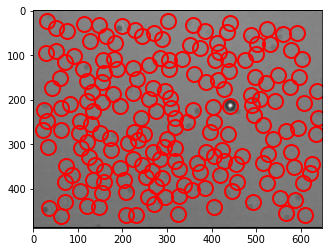

In [35]:
#Show first frame of the video with the particle localization
f = tp.locate(as_gray(video[len(video)-1]), 19, invert=False) #len(video)-1
plt.figure() #make a new figure
tp.annotate(f, as_gray(video[len(video)-1]));

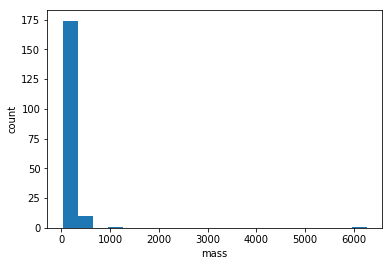

In [36]:
#Histogram of brightness mass to correct the wrong particle localization
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

#label the axes
ax.set(xlabel='mass', ylabel='count');

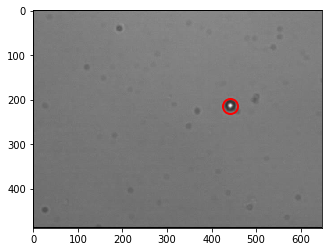

In [37]:
f = tp.locate(as_gray(video[len(video)-1]), 19, invert=False, minmass=4000)
plt.figure()
tp.annotate(f, video[len(video)-1])

In [38]:
#Location of features in all the frames
f = tp.batch(as_gray(video[:]), 19, minmass = 4000, invert=False);

Frame 4749: 1 features


Frame 4749: 1 trajectories present.


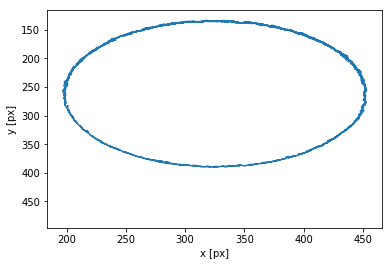

In [39]:
t = tp.link_df(f, 20, memory=60) #Link of trajectories: max displacement = 20, memory 60 frames

#Trace the trajectories
plt.figure()
tp.plot_traj(t);

In [40]:
t.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,249.212124,197.925615,5763.449762,3.089761,0.035374,138.557527,26258.0,-0.087542,0,0
1,247.120867,197.657880,5795.445202,3.118275,0.036141,135.730945,26415.0,-0.065659,1,0
2,244.501110,198.104903,5734.546733,3.130185,0.026149,135.273767,26372.0,-0.092991,2,0
3,242.267736,198.519157,5712.974051,3.133433,0.046025,135.807624,26207.0,-0.075433,3,0
4,241.268431,199.141876,5726.847030,3.101367,0.026723,135.593871,26457.0,-0.077903,4,0


In [41]:
t.to_csv("Tracking_Test56_20191128.dat", sep='\t')

# Filtering particles

In [44]:
import support as sp

In [45]:
#trj = t.filter(["frame", "particle", "x", "y"])
trj = t
trj = trj.set_index(["frame", "particle"])
trj = trj.sort_index()

trj.head()

,,y,x,mass,size,ecc,signal,raw_mass,ep
frame,particle,,,,,,,,
0,0,249.212124,197.925615,5763.449762,3.089761,0.035374,138.557527,26258.0,-0.087542
1,0,247.120867,197.657880,5795.445202,3.118275,0.036141,135.730945,26415.0,-0.065659
2,0,244.501110,198.104903,5734.546733,3.130185,0.026149,135.273767,26372.0,-0.092991
3,0,242.267736,198.519157,5712.974051,3.133433,0.046025,135.807624,26207.0,-0.075433
4,0,241.268431,199.141876,5726.847030,3.101367,0.026723,135.593871,26457.0,-0.077903


In [46]:
trj = sp.changeToPolarCoordinates(trj)

trj.head()

,,y,x,mass,size,ecc,signal,raw_mass,ep,r,theta
frame,particle,,,,,,,,,,
0,0,-12.707416,-127.390650,5763.449762,3.089761,0.035374,138.557527,26258.0,-0.087542,128.022874,-3.042170
1,0,-14.798673,-127.658385,5795.445202,3.118275,0.036141,135.730945,26415.0,-0.065659,128.513283,-3.026184
2,0,-17.418430,-127.211363,5734.546733,3.130185,0.026149,135.273767,26372.0,-0.092991,128.398335,-3.005514
3,0,-19.651804,-126.797108,5712.974051,3.133433,0.046025,135.807624,26207.0,-0.075433,128.310951,-2.987830
4,0,-20.651109,-126.174390,5726.847030,3.101367,0.026723,135.593871,26457.0,-0.077903,127.853216,-2.979360


In [47]:
len(trj[trj.r<trj.r.mean()].index.get_level_values("particle").unique())

1

In [48]:
len(trj[trj.r>trj.r.mean()].index.get_level_values("particle").unique())

2

In [49]:
new_t = trj[trj.r<trj.r.mean()]
new_t = new_t.reset_index()
del new_t["r"], new_t["theta"]
new_t.head()

,frame,particle,y,x,mass,size,ecc,signal,raw_mass,ep
0,12,0,-21.577281,-125.357589,5741.090919,3.115849,0.025392,135.641451,26319.0,-0.065692
1,13,0,-19.798496,-125.630791,5752.874094,3.102616,0.034446,138.186030,26484.0,-0.035209
2,14,0,-19.471170,-125.458448,5684.982607,3.113549,0.027017,136.955179,26217.0,-0.083813
3,15,0,-20.273446,-125.422187,5738.894700,3.109797,0.021401,135.614693,26316.0,-0.085260
4,16,0,-22.796553,-124.882700,5767.978379,3.146729,0.043105,134.593200,26394.0,-0.074189


In [50]:
len(new_t.particle.unique())

1

In [51]:
new_t.to_csv("Tracking_Test56_20191128.dat", sep='\t')